In [1]:
import pandas as pd

# Load and check data format
df = pd.read_csv('Training_Data.csv')
print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))
df.head()

Number of instances = 3177
Number of attributes = 9


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
4,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


Text(0.5, 1.0, 'Correlation Matrix')

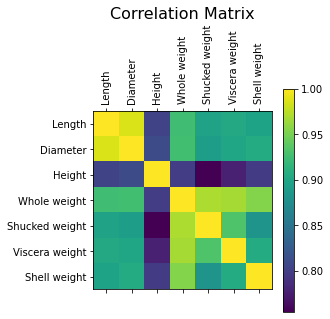

In [2]:
import matplotlib.pyplot as plt

# Compute correlation matrix to see if any variables should be removed
corr = df.drop('Rings', axis=1).corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=16)

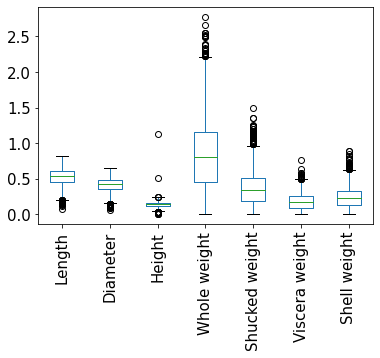

In [3]:
# Visualize box plots to check for outliers
boxplot = df.drop('Rings', axis=1).boxplot(grid=False, rot=90, fontsize=15)  

In [4]:
# # Remove Length because of its high correlation with Diameter
# df.drop('Length', axis=1, inplace=True)

# One Hot Encode the Sex column because it is a categorical variable
df = df.join(pd.get_dummies(df.Sex, prefix='Sex'), lsuffix='_caller', rsuffix='_other')
# Remove the encoded column
df.drop('Sex', axis=1, inplace=True)

# # Add a new variable
# df['Testing shit'] = df['Height']*df['Diameter']

# Place the target column at the last index
df['Rings'] = df.pop('Rings')
print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))
df.head()

Number of instances = 3177
Number of attributes = 11


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,7
2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,10
3,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,0,1,0,8
4,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,1,0,0,20


In [5]:
from sklearn.model_selection import train_test_split

# Convert to numpy arrays
X = df.drop('Rings', axis=1).to_numpy()
y = df['Rings'].to_numpy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2541, 10), (636, 10), (2541,), (636,))

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Try linear regression as a baseline, without any cross validation
lreg = LinearRegression()
lreg.fit(X_train, y_train)
lreg_pred = lreg.predict(X_test)
print('Linear regression MSE = %.4f' % (mean_squared_error(y_test, lreg_pred)))
print('Linear regression R2 = %.4f' % (r2_score(y_test, lreg_pred)))

Linear regression MSE = 4.7600
Linear regression R2 = 0.5634


In [7]:
from sklearn.linear_model import LassoCV

# Number of folds used for cross validation
n_folds = 4

# Cross validated Lasso regression
lasso = LassoCV(cv=n_folds, alphas=[1e-3, 1e-2, 1e-1]).fit(X, y)
lasso_pred = lasso.predict(X_test)
print('Lasso regression MSE = %.4f' % (mean_squared_error(y_test, lasso_pred)))
print('Lasso regression R2 = %.4f' % (r2_score(y_test, lasso_pred)))
print('With alpha = %.3f' % (lasso.alpha_))

Lasso regression MSE = 4.7030
Lasso regression R2 = 0.5686
With alpha = 0.001


In [8]:
from sklearn.linear_model import ElasticNetCV

# Cross validated ElasticNet regression
elastic = ElasticNetCV(cv=n_folds, l1_ratio=[0.25,0.5,0.75], alphas=[1e-3, 1e-2, 1e-1]).fit(X_train, y_train)
elastic_pred = elastic.predict(X_test)
print('Elastic regression MSE = %.4f' % (mean_squared_error(y_test, elastic_pred)))
print('Elastic regression R2 = %.4f' % (r2_score(y_test, elastic_pred)))
print('With alpha = %.3f' % (elastic.alpha_))
print('And l1_ratio = %.2f' % (elastic.l1_ratio_))

Elastic regression MSE = 4.8415
Elastic regression R2 = 0.5559
With alpha = 0.001
And l1_ratio = 0.75


In [9]:
from sklearn.linear_model import RidgeCV

# Cross validated Ridge regression
ridge = RidgeCV(cv=n_folds, alphas=[1e-3, 1e-2, 1e-1, 1])
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print('Ridge regression MSE = %.4f' % (mean_squared_error(y_test, ridge_pred)))
print('Ridge regression R2 = %.4f' % (r2_score(y_test, ridge_pred)))
print('With alpha = %.3f' % (ridge.alpha_))

Ridge regression MSE = 4.8504
Ridge regression R2 = 0.5551
With alpha = 1.000


In [10]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

# Cross validated Gradient Boosting Regressor
gbr = ensemble.GradientBoostingRegressor()

gbr_params = {
    'n_estimators': [500,1000,2000],
    'max_depth': [3,4],
    'min_samples_split': [2,5],
    'learning_rate': [1e-3,1e-2],
    'loss': ['squared_error'],
}

# Optimize hyperparameters with a grid search
gbr_grid_search = GridSearchCV(gbr, gbr_params, cv = n_folds, n_jobs = -1)
gbr_grid_search.fit(X_train, y_train)
best_gbr = gbr_grid_search.best_estimator_
gbr_pred = best_gbr.predict(X_test)
print('GBR regression MSE = %.4f' % (mean_squared_error(y_test, gbr_pred)))
print('GBR regression R2 = %.4f' % (r2_score(y_test, gbr_pred)))
print("\n".join("{}\t{}".format(k, v) for k, v in gbr_grid_search.best_params_.items()))

GBR regression MSE = 5.1134
GBR regression R2 = 0.5309
learning_rate	0.01
loss	squared_error
max_depth	3
min_samples_split	5
n_estimators	1000


In [11]:
from sklearn import svm

svr = svm.SVR()

svr_params = {
    'kernel': ('linear', 'rbf'),
    'C':[1, 10],
    'tol': [1e-7, 1e-4],
    'epsilon':[0.1,0.2,0.3,0.5]
}

svr_grid_search = GridSearchCV(svr, svr_params, cv = n_folds, n_jobs = -1)
svr_grid_search.fit(X_train, y_train)
best_svr = svr_grid_search.best_estimator_
svr_pred = best_svr.predict(X_test)
print('SVR regression MSE = %.4f' % (mean_squared_error(y_test, svr_pred)))
print('SVR regression R2 = %.4f' % (r2_score(y_test, svr_pred)))
print("\n".join("{}\t{}".format(k, v) for k, v in svr_grid_search.best_params_.items()))

SVR regression MSE = 4.5618
SVR regression R2 = 0.5815
C	10
epsilon	0.5
kernel	rbf
tol	0.0001


In [12]:
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold

# Building the neural network
def get_dnn(act):    
    dnn = Sequential()
    dnn.add(Dense(64, act, ))
    dnn.add(Dense(32, act))
    dnn.add(Dense(8, act))
    dnn.add(Dense(1))
    dnn.compile(optimizer='Adam', loss='mse', metrics=['mse'])
    return dnn

# Split the training set for KFold cross validation
kf = KFold(n_splits=n_folds)

# Try each activation function (one fold, one function)
activation_functions = ['selu', 'tanh', 'linear', 'relu']
fold_counter = 0
for train_idx, val_idx in kf.split(X_train, y_train):
    fold_counter+=1
    fold_act = activation_functions[fold_counter-1]
    # Training and validation data for each fold
    fold_X_train = X_train[train_idx]
    fold_y_train = y_train[train_idx]
    fold_X_val = X_train[val_idx]
    fold_y_val = y_train[val_idx]
    # Build a neural network with a specific activation function
    dnn = get_dnn(fold_act)
    # verbose=0, Make the fit silent because output is otherwise too large
    dnn.fit(fold_X_train, fold_y_train, epochs=50, validation_data=(fold_X_val, fold_y_val), verbose=0)
    fold_pred = dnn.predict(X_test)
    fold_mse = mean_squared_error(y_test,fold_pred)
    fold_r2 = r2_score(y_test, fold_pred)
    print('DNN regression with {act}, MSE = %.4f'.format(act = fold_act) % (fold_mse))
    print('DNN regression with {act}, R2 = %.4f'.format(act = fold_act) % (fold_r2))
    print('---------------------------------------')

DNN regression with selu, MSE = 4.4956
DNN regression with selu, R2 = 0.5876
---------------------------------------
DNN regression with tanh, MSE = 5.5138
DNN regression with tanh, R2 = 0.4942
---------------------------------------
DNN regression with linear, MSE = 4.8865
DNN regression with linear, R2 = 0.5518
---------------------------------------
DNN regression with relu, MSE = 4.5910
DNN regression with relu, R2 = 0.5789
---------------------------------------


In [13]:
# Best activation function is indeed SELU
dnn = get_dnn('selu')
# Split the training data to get some validation data for the neural network
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)
# Training the model on the full training set
dnn.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
dnn_pred = dnn.predict(X_test)
print('DNN regression MSE = %.4f' % (mean_squared_error(y_test, dnn_pred)))
print('DNN regression R2 = %.4f' % (r2_score(y_test, dnn_pred)))

Epoch 1/50
60/60 [==============================] - 0s 3ms/step - loss: 28.6971 - mse: 28.6971 - val_loss: 7.9641 - val_mse: 7.9641
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 6.8263 - mse: 6.8263 - val_loss: 7.7284 - val_mse: 7.7284
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 6.6836 - mse: 6.6836 - val_loss: 7.6497 - val_mse: 7.6497
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 6.6175 - mse: 6.6175 - val_loss: 7.5207 - val_mse: 7.5207
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 6.5411 - mse: 6.5411 - val_loss: 7.4475 - val_mse: 7.4475
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 6.4587 - mse: 6.4587 - val_loss: 7.3615 - val_mse: 7.3615
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 6.3628 - mse: 6.3628 - val_loss: 7.2580 - val_mse: 7.2580
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 6.2764 - mse: 6.